In [1]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pickle
import gzip
import torch
import math

In [2]:
from copy import copy
from pathlib import Path
from matplotlib import pyplot as plt
from torch.autograd import Variable
# import tensorflow as tf

In [3]:
def prepare_data():
    DATA_PATH = Path("data")
    PATH = DATA_PATH / "mnist"
 
    PATH.mkdir(parents=True, exist_ok=True)
 
    URL = "http://deeplearning.net/data/mnist/"
    FILENAME = "mnist.pkl.gz"
 
    if not (PATH / FILENAME).exists():
            content = requests.get(URL + FILENAME).content
            (PATH / FILENAME).open("wb").write(content)
 
    with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
            ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
 
    x_train, y_train, x_valid, y_valid = map(
        torch.tensor, (x_train, y_train, x_valid, y_valid)
    )
   
    return x_train, y_train


In [4]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
 
def model(xb):
    return log_softmax(xb @ y_weights + y_bias)
 
def nll(input_, target):
    return -input_[range(target.shape[0]), target].mean()
 
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [5]:
y_weights = torch.randn(784, 10) / math.sqrt(784)
y_weights.requires_grad_()
u_weights = torch.randn(784, 10) / math.sqrt(784)
u_weights.requires_grad_()
y_bias = torch.zeros(10, requires_grad=True)
u_bias = torch.zeros(10, requires_grad=True)
alpha_k = 0.01
A_k = 0.0
M_k = 2 # Change it later
L_k = 6 * M_k
max_iter = 100 # how many iters to train for

In [6]:
x_train, y_train = prepare_data()
loss_func = nll

In [7]:
losses_values = []
accuracy_values = []

In [8]:
def count_new_y(y, M_k, x_k):
    return -y.grad / M_k + x_weights

In [9]:
import tqdm

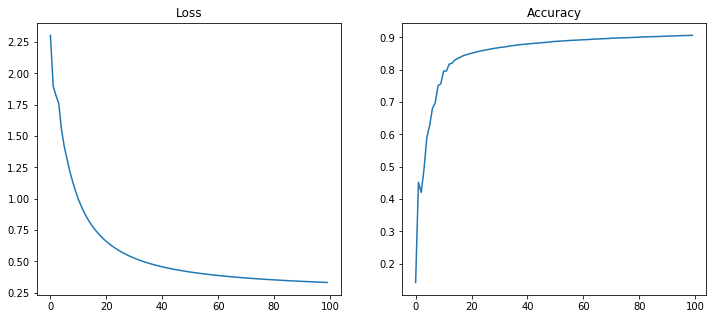

In [10]:
for iter_num in range(max_iter):
    pred = model(x_train)
    loss = loss_func(pred, y_train)
    accuracy_val = accuracy(pred, y_train)
   
    losses_values.append(loss)
    accuracy_values.append(accuracy_val)

    loss.backward()

    with torch.no_grad():
        alpha_k = (1 / L_k + np.sqrt(1 / L_k**2 + 4 * A_k / L_k))/2
        A_k_next = A_k + alpha_k

        x_weights = y_weights * A_k / A_k_next + u_weights * alpha_k / A_k_next
        x_bias = y_bias * A_k / A_k_next + u_bias * alpha_k / A_k_next
#         new_y = count_new_y(-y_weights.grad, M_k, x_weights)
        y_weights.copy_(count_new_y(y_weights, M_k, x_weights))
#         y_weights.copy_(-y_weights.grad / M_k + x_weights)
        y_bias.copy_(-y_bias.grad / M_k + x_bias)
        u_weights.copy_(u_weights - alpha_k * y_weights.grad)
        u_bias.copy_(u_bias - alpha_k * y_bias.grad)
       
        y_weights.grad.zero_()
        y_bias.grad.zero_() 
        A_k = copy(A_k_next)
 
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].plot([losses_values[i].detach() for i in range(max_iter)])
ax[1].plot(accuracy_values)
plt.show()

In [11]:
torch.tensor(3.07)

tensor(3.0700)

In [12]:
y_weights = torch.randn(784, 10) / math.sqrt(784)
y_weights.requires_grad_()
u_weights = torch.randn(784, 10) / math.sqrt(784)
u_weights.requires_grad_()
y_bias = torch.zeros(10, requires_grad=True)
u_bias = torch.zeros(10, requires_grad=True)
alpha_k = 0.01
A_k = 0.0
M_k = 2.0 # Change it later
L_k = 6 * M_k
L_k_rate = 1.1
max_iter = 100 # how many iters to train for

In [13]:
x_train, y_train = prepare_data()
loss_func = nll

In [14]:
losses_values = []
accuracy_values = []

In [15]:
import tqdm
from torch import matmul, norm

In [16]:
class T_counter():
    def __init__(self, gd_eps=1e-6, max_gd_iters=200):
        self.gd_eps = gd_eps
        self.max_gd_iters = max_gd_iters
    
    def cubic_regularization(self, grad, hess, x, M):
        df = grad
        ddf = hess
        
        t = torch.zeros_like(x, requires_grad=True)
        opt = torch.optim.SGD([t], lr=0.01, momentum=0.9)

        for i in range(self.max_gd_iters):
            loss = torch.sum(df*t) + 0.5 * torch.sum(t*torch.sum(ddf*t, axis=(2,3))) + (M / 6) * torch.norm(t).pow(3)
#             loss = torch.sum(torch.sum(df * t)) + 0.5 * torch.sum(torch.sum(t * matmul(ddf, t))) + (M / 6) * torch.norm(t).pow(3)
            loss.backward()
            ng = norm(t.grad)
            if ng < self.gd_eps:
                break
            
            opt.step()
            opt.zero_grad()
        
        t.requires_grad = False

        return x + t

In [17]:
weights_counter = T_counter()

In [18]:
def count_new_y_p_2(loss, y_weights, M_k, x_k):
    (grads,)  = torch.autograd.grad(loss, y_weights, create_graph=True)

    grads2 = []
    for grad in tqdm.tqdm(grads):
        grads2_tmp = []
        for g in grad:
            g2 = torch.autograd.grad(g, y_weights, create_graph=True)[0]
            grads2_tmp.append(g2)
        grads2_tmp = torch.stack(grads2_tmp)
        grads2.append(grads2_tmp)
#     print(grads2)
    grads2 = torch.stack(grads2)

    return weights_counter.cubic_regularization(grads, grads2, y_weights, M_k)

In [ ]:
for iter_num in range(max_iter):
    pred = model(x_train)
    loss = loss_func(pred, y_train)
    accuracy_val = accuracy(pred, y_train)
   
    losses_values.append(loss)
    accuracy_values.append(accuracy_val)

    while True:
        alpha_k = (1 / L_k + np.sqrt(1 / L_k**2 + 4 * A_k / L_k))/2
        A_k_next = A_k + alpha_k

        x_weights = y_weights * A_k / A_k_next + u_weights * alpha_k / A_k_next
        x_bias = y_bias * A_k / A_k_next + u_bias * alpha_k / A_k_next

        y_weights.copy_(count_new_y_p_2(loss, y_weights, M_k, x_weights))

        y_bias.copy_(-y_bias.grad / M_k + x_bias)
        u_weights.copy_(u_weights - alpha_k * y_weights.grad)
        u_bias.copy_(u_bias - alpha_k * y_bias.grad)
        
        print(1)

        if (6 * M_k / (2 * L_k) * torch.norm(y_weights - x_weights) >= 0.5) and \
        (6 * M_k / (2 * L_k) * torch.norm(y_weights - x_weights) <= 1.0):
            break
        elif (6 * M_k / (2 * L_k) * torch.norm(y_weights - x_weights) >= 0.5):
            L_k /= L_k_rate
        else:
            L_k *= L_k_rate


    loss.backward()
    with torch.no_grad():
        y_weights.grad.zero_()
        y_bias.grad.zero_() 
        A_k = copy(A_k_next)
    print(loss)
 
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].plot([losses_values[i].detach() for i in range(max_iter)])
ax[1].plot(accuracy_values)
plt.show()

  2%|▏         | 17/784 [00:07<06:14,  2.05it/s]

In [4]:
x_tensor = torch.Tensor([[1, 2], [3, 4]])
y_tensor = torch.Tensor([[5, 6], [7, 8]])
x_tensor * y_tensor

tensor([[ 5., 12.],
        [21., 32.]])